In [1]:
from datasets import load_dataset_builder
from datasets import load_dataset
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

from datasets import ClassLabel, Sequence
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

from transformers import AutoTokenizer, GPT2Tokenizer, GPT2LMHeadModel 

import numpy as np
import time

from collections import OrderedDict

from torch_geometric.nn import GCNConv, SimpleConv
from tqdm.auto import tqdm

from torch_geometric.data import Batch

from sklearn.manifold import TSNE

## Helper function

In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    

class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
        
        
def tokenize_data(examples):
    tokenized_inputs = tokenizer(examples["sentence"], truncation=True)

    return tokenized_inputs

## Load in the CoLA dataset from GLUE benchmark

In [3]:
from datasets import load_dataset, load_metric

task = "cola"

actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

Reusing dataset glue (/n/home04/yidachen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

## Convert text to sequence of tokens

In [4]:
model_checkpoint = "gpt2"
batch_size = 16

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
dataset["train"][0]

tokenized_datasets = dataset.map(tokenize_data, batched=True)

Loading cached processed dataset at /n/home04/yidachen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-bc767f25de318367.arrow
Loading cached processed dataset at /n/home04/yidachen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-509cd2ed72f3b68c.arrow
Loading cached processed dataset at /n/home04/yidachen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-03829d6744892fb1.arrow


## Create Train & Test Split for Probing Evaluation

In [5]:
np.random.seed(123)

split = "validation"
num_samples = len(dataset[split])
train_portion = 0.8

sampled_indices = np.random.choice(np.arange(len(tokenized_datasets[split])),
                                   num_samples, 
                                   replace=False)


sampled_train = np.random.choice(np.arange(len(sampled_indices)), 
                                 int(num_samples * train_portion), 
                                 replace=False)


sampled_test = np.setdiff1d(np.arange(len(sampled_indices)), sampled_train)


train_mask = np.array([True] * num_samples)
train_mask[sampled_test] = False


test_mask = np.array([True] * num_samples)
test_mask[sampled_train] = False

In [6]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
        
threshold = 0.2 
    
all_graphs = {}
for layer in range(12):
    all_graphs[layer] = {}
    for head in range(12):
        all_graphs[layer][head] = []
    
# graphs = []

for i in tqdm(sampled_indices):
    features = OrderedDict()
    for name, module in model.named_modules():
        if "c_attn" in name:
            features[name] = ModuleHook(module)


    with torch.no_grad():
        output = model(input_ids = torch.Tensor(tokenized_datasets[split]["input_ids"][i]).type(torch.long).to("cuda"),
                       attention_mask = torch.Tensor(tokenized_datasets[split]["attention_mask"][i]).to("cuda"),
                       output_attentions = True,
                       output_hidden_states = True)


    for feature in features.values():
        feature.close()

    y = tokenized_datasets[split]["label"][i]
    for layer in range(12):
        value_features = features[f'transformer.h.{layer}.attn.c_attn'].features[0].split(768, dim=2)[-1][0].clone()
        for head in range(12):
            weighted_adj_matrix = output["attentions"][layer][0][head].detach().cpu()

            # node_features = output["hidden_states"][layer - 1][0].detach().cpu()

            node_features = value_features[:, head * 64: (head + 1) * 64]

            adj_matrix = weighted_adj_matrix > threshold

            edge_index = adj_matrix.detach().clone().cpu().nonzero().t().contiguous().type(torch.long)
            x = node_features

            data = Data(x=x, edge_index=edge_index, y=y)

            all_graphs[layer][head].append(data)

  0%|          | 0/1043 [00:00<?, ?it/s]

## Graph Neural Network

In [7]:
from gcn_probe import GCNProbe, GCNNonlinearProbe, MLPProbe

## Train and Test Helper functions

In [8]:
def train(model, optimizer, criterion, loader):
    model.train()
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.to("cuda"))  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    return loss
        
        
def test(model, loader, metric):
    model.eval()
    correct = 0
    
    preds = torch.Tensor([]).to("cuda")
    refs = torch.Tensor([]).to("cuda")
    
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y.to("cuda")).sum())  # Check against ground-truth labels.
        
        preds = torch.concat([preds, pred])
        refs = torch.concat([refs, data.y.to("cuda")])
        
    accuracy = metric.compute(predictions=preds, references=refs)
        
    return correct / len(loader.dataset), accuracy, preds, refs  # Derive ratio of correct predictions.

## Create Train Test Dataset

In [9]:
from torch_geometric.loader import DataLoader

metric = load_metric('glue', actual_task)

train_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]]
test_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Train and Test Helper functions

In [10]:
def train(model, optimizer, criterion, loader):
    model.train()
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.to("cuda"))  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    return loss
        
        
def test(model, loader):
    model.eval()
    correct = 0
    preds = torch.Tensor([]).to("cuda")
    refs = torch.Tensor([]).to("cuda")
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y.to("cuda")).sum())  # Check against ground-truth labels.
        preds = torch.concat([preds, pred])
        refs = torch.concat([refs, data.y.to("cuda")])
        
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

## Convert the large dataset into set of mini-batches

In [11]:
from torch_geometric.loader import DataLoader

train_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]]
test_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[608, 64], edge_index=[2, 700], y=[64], batch=[608], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[701, 64], edge_index=[2, 812], y=[64], batch=[701], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[613, 64], edge_index=[2, 699], y=[64], batch=[613], ptr=[65])

Step 4:
Number of graphs in the current batch: 17
DataBatch(x=[156, 64], edge_index=[2, 190], y=[17], batch=[156], ptr=[18])



## Train Probe on Graph representations of Text at 144 Heads

In [12]:
train_accs = {}
test_accs = {}

for layer in tqdm(range(12)):
    train_accs[layer] = {}
    test_accs[layer] = {}
    for head in range(12):
        probe = GCNProbe(64, 2).to("cuda")

        optimizer = torch.optim.Adam(probe.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        train_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if train_mask[i]]
        test_dataset = [all_graphs[layer][head][i].to("cuda") for i in range(len(all_graphs[layer][head])) if test_mask[i]]

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        for epoch in range(1, 201):
            loss = train(probe, optimizer, criterion, train_loader)
            train_acc = test(probe, train_loader)

            # if (epoch - 1) % 20 == 0:
            #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            #     print(f'Train Accuracy: {train_acc:.4f}')

        print("-" * 25 + f" layer {layer} head {head} " + "-" * 25)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')
        
        test_acc = test(probe, test_loader)
        print(f'Test Accuracy: {test_acc:.4f}')
        
        train_accs[layer][head] = train_acc
        test_accs[layer][head] = test_acc

  0%|          | 0/12 [00:00<?, ?it/s]

------------------------- layer 0 head 0 -------------------------
Epoch: 200, Loss: 1.0294
Train Accuracy: 0.7062
Test Accuracy: 0.6411
------------------------- layer 0 head 1 -------------------------
Epoch: 200, Loss: 1.2941
Train Accuracy: 0.6966
Test Accuracy: 0.6794
------------------------- layer 0 head 2 -------------------------
Epoch: 200, Loss: 0.4831
Train Accuracy: 0.7146
Test Accuracy: 0.6172
------------------------- layer 0 head 3 -------------------------
Epoch: 200, Loss: 0.4057
Train Accuracy: 0.7086
Test Accuracy: 0.6459
------------------------- layer 0 head 4 -------------------------
Epoch: 200, Loss: 0.8618
Train Accuracy: 0.6978
Test Accuracy: 0.6364
------------------------- layer 0 head 5 -------------------------
Epoch: 200, Loss: 0.1940
Train Accuracy: 0.7134
Test Accuracy: 0.6651
------------------------- layer 0 head 6 -------------------------
Epoch: 200, Loss: 1.4317
Train Accuracy: 0.7038
Test Accuracy: 0.6411
------------------------- layer 0 head 7 

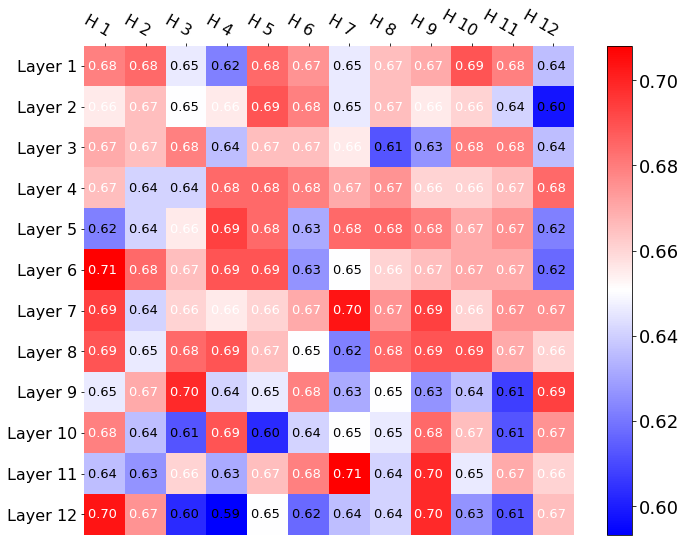

In [14]:
from visualization_utils import heatmap, annotate_heatmap
import matplotlib.pyplot as plt
import numpy as np

score_matrix = []

for layer in range(12):
    score_matrix.append([])
    for head in range(12):
        score_matrix[layer].append(test_accs[layer][head])

plt.figure(figsize=(12, 9))

im, cbar = heatmap(np.array(score_matrix), [f"Layer {i + 1}" for i in range(12)], [f"H {i + 1}" for i in range(12)],
        cmap="bwr")

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(18)

texts = annotate_heatmap(im, valfmt="{x:.2f} ", fontsize=13)

In [13]:
inputs = tokenizer('"The wagon rumbled down the road."\nGrammatically correct? Correct\n###\n\n"We yelled ourselves hoarse."\nGrammatically correct? Correct\n###\n\n"They drank the pub."\nGrammatically correct? Incorrect\n###\n\n"They made him to exhaustion."\nGrammatically correct? Incorrect\n###\n\n"We drove Highway 5 from SD to SF."\nGrammatically correct? Correct\n###\n\n"Bill ate off the floor."\nGrammatically correct?', return_tensors="pt")
inputs.to("cuda")
generation_output = model.generate(**inputs, return_dict_in_generate=True, output_scores=True, max_length=160,)

for i, beam in enumerate(generation_output.sequences):
    print(f"{i}: {tokenizer.decode(beam, skip_special_tokens=True)}")
    print()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: "The wagon rumbled down the road."
Grammatically correct? Correct
###

"We yelled ourselves hoarse."
Grammatically correct? Correct
###

"They drank the pub."
Grammatically correct? Incorrect
###

"They made him to exhaustion."
Grammatically correct? Incorrect
###

"We drove Highway 5 from SD to SF."
Grammatically correct? Correct
###

"Bill ate off the floor."
Grammatically correct? Incorrect

###

"They were so drunk that they couldn't even get out of bed."
Grammatically correct? Incorrect

###

"They were so drunk that they couldn't even get out of bed."


